In [18]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,BB_SMA,BB_STD,Upper_Band,Lower_Band,MACD_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
19,367.940002,369.000000,365.649994,367.750000,13719379,367.920408,369.239200,-1.318792,-1.398221,0.079429,370.934052,5.659634,382.253320,359.614783,NaN,NaN,NaN,0,NaN,NaN
20,365.839996,368.059998,365.679993,367.954987,14519611,367.590462,368.931499,-1.341037,-1.386678,0.045641,370.299551,5.471442,381.242436,359.356667,1.0,0.0,1.0,0,-0.005707,0.000000
21,375.109985,375.540009,371.890686,372.000000,18258674,368.777394,369.480307,-0.702913,-1.248908,0.545995,370.221001,5.385609,380.992219,359.449783,1.0,0.0,1.0,0,0.019487,0.000000
22,375.179993,376.250000,374.950012,375.119995,8869727,369.783996,369.977928,-0.193931,-1.036660,0.842728,370.079001,5.203516,380.486033,359.671969,1.0,0.0,1.0,0,0.019677,0.000000
23,374.739990,375.639008,373.910004,375.250000,7976852,370.560548,370.387189,0.173359,-0.793508,0.966867,369.943500,5.033994,380.011488,359.875512,1.0,0.0,1.0,0,0.018481,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,587.691711,588.440002,586.960022,587.690002,8810868,580.487480,573.958612,6.528868,4.974162,1.554706,573.929584,9.339642,592.608867,555.250301,1.0,0.0,1.0,0,0.597249,0.070837
5082,588.330017,588.390015,587.289978,587.659973,5181652,581.694024,574.985141,6.708883,5.321106,1.387777,574.944583,9.758431,594.461445,555.427722,1.0,0.0,1.0,0,0.598984,0.070837
5083,587.890015,589.069885,587.460022,588.335022,7405702,582.647253,575.906917,6.740336,5.604952,1.135384,575.888083,10.062940,596.013962,555.762203,1.0,0.0,1.0,0,0.597788,0.070837
5084,588.450012,588.960022,587.489929,587.919983,6511291,583.539985,576.802853,6.737133,5.831388,0.905745,577.065085,10.087952,597.240989,556.889180,1.0,0.0,1.0,0,0.599310,0.070837


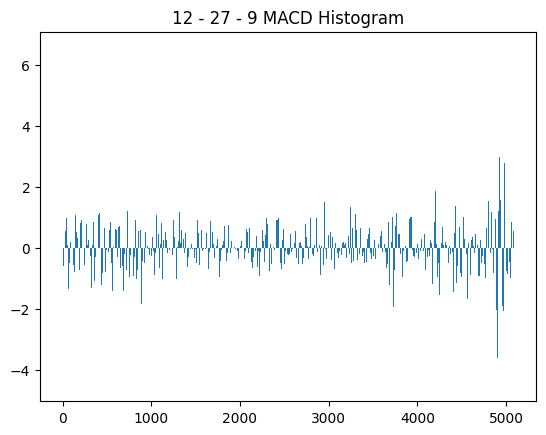

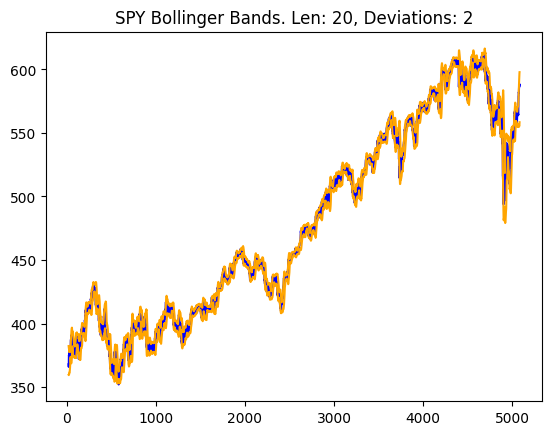

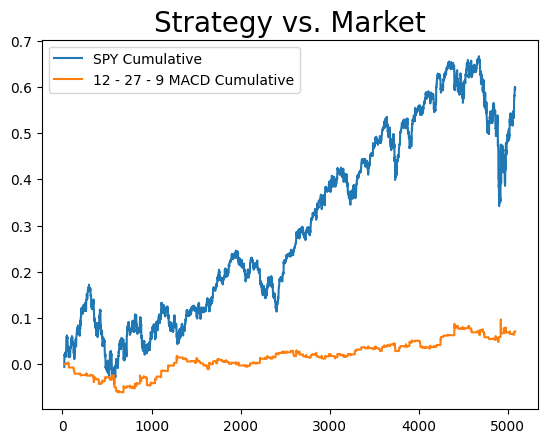

In [19]:
TICKER = 'SPY'
INTERVAL='1h'
BB_LEN = 20
DEVS = 2

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MFI_LENGTH = 14
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_bollinger_bands(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], 1, 
        np.where(df['Close'] < df['Lower_Band'], -1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_bollinger_bands(df)
    df = add_MACD_strategy(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

In [20]:
df['Full_Strategy'].value_counts()

Full_Strategy
-1.0    2334
 1.0    2168
 2.0     264
-2.0     258
 0.0      42
Name: count, dtype: int64